Install torch

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

"The objective of this project is to design a mini “deep learning framework” using only pytorch’s
tensor operations and the standard math library, hence in particular without using autograd or the
neural-network modules."

"Your framework should import only torch.FloatTensor and torch.LongTensor from pytorch, and
use no pre-existing neural-network python toolbox"

"Your framework must provide the necessary tools to:
• build networks combining fully connected layers, Tanh, and ReLU,
• run the forward and backward passes,
• optimize parameters with SGD for MSE."

"You must implement a test executable named test.py that imports your framework and
• Generates a training and a test set of 1, 000 points sampled uniformly in [0, 1]^2, each with a
label 0 if outside the disk of radius 1/√2π and 1 inside,
• builds a network with two input units, two output units, three hidden layers of 25 units,
• trains it with MSE, logging the loss,
• computes and prints the final train and the test errors."

class Module ( object ) :
  def forward ( self , * input ) :
    raise NotImplementedError
  def backward ( self , * gradwrtoutput ) :
    raise NotImplementedError
  def param ( self ) :
    return []

"Each such module may have tensor parameters, in which case it should also have for each a similarly
sized tensor gradient to accumulate the gradient during the back-pass, and
• forward should get for input, and returns, a tensor or a tuple of tensors.
• backward should get as input a tensor or a tuple of tensors containing the gradient of the loss
with respect to the module’s output, accumulate the gradient wrt the parameters, and return a
tensor or a tuple of tensors containing the gradient of the loss wrt the module’s input.
• param should return a list of pairs, each composed of a parameter tensor, and a gradient tensor
of same size. This list should be empty for parameterless modules (e.g. ReLU).
Some modules may requires additional methods, and some modules may keep track of information
from the forward pass to be used in the backward."

"You should implement at least the modules Linear (fully connected layer), ReLU , Tanh , Sequential
to combine several modules in basic sequential structure, and LossMSE to compute the MSE loss."

Import statements.

In [1]:
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import FloatTensor, LongTensor

In [2]:
def generate_data(minn=0, maxx=1, radius=1/np.sqrt(2*np.pi), center=np.array([0.5, 0.5]), num_of_points=1000, is_torch=False):
  points = np.random.uniform(low=minn, high=maxx, size=(num_of_points, 2))
  labels = (np.sum(np.square(center - points), axis=1) <= np.square(radius)).astype(np.float)
  
  if is_torch:
    points = torch.from_numpy(points)
    labels = torch.from_numpy(labels)
    
    points, labels = points.type(torch.FloatTensor), labels.type(torch.FloatTensor)
    
  return points, labels

def generate_grid_data(minn=0, maxx=1, num_of_points_per_dim=51, is_torch=False):
  coor_x = np.linspace(minn, maxx, num_of_points_per_dim)
  coor_y = np.linspace(minn, maxx, num_of_points_per_dim)
  xx, yy = np.meshgrid(coor_x, coor_y)
  points = np.array([xx.flatten(), yy.flatten()]).T
  
  if is_torch:
    points = torch.from_numpy(points)
    
    points = points.type(torch.FloatTensor)
    
  return points

def plot_data(points, labels=0, minn=0, maxx=1, radius=1/np.sqrt(2*np.pi), center=np.array([0.5, 0.5])):
  circle = plt.Circle(center, radius, color='r', fill=False, linewidth=5)
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.add_patch(circle)
  ax.scatter(points[:,0], points[:,1], c=labels)
  ax.set_xlim(minn, maxx)
  ax.set_ylim(minn, maxx)
  

In [3]:
points, labels = generate_data()
plot_data(points, labels)

In [4]:
class Module(object):
  def forward(self,*input):
    raise NotImplementedError
  def backward (self,*gradwrtoutput):
    raise NotImplementedError
  def param(self):
    return []
  def set_param(self, name, value):
    pass
  
class LossModule(Module):
  def forward(self,*input):
    raise NotImplementedError
  def backward (self,*gradwrtoutput):
    raise NotImplementedError
  def param(self):
    return []
  def set_param(self, name, value):
    pass

In [5]:
class Linear(Module):
  
  def __init__(self, in_num, out_num, is_bias=True, is_trainable=True):
    super(Linear, self).__init__()
    self.in_num = in_num
    self.out_num = out_num
    self.is_trainable = is_trainable
    
    self.input = None
    
    self.params = OrderedDict()
    self.grads = OrderedDict()
    
    self.params["weight"] = FloatTensor(in_num, out_num)
    self.grads["weight"] = None
    
    self.is_bias = is_bias
    
    if is_bias:
        self.params["bias"] = FloatTensor(out_num)
        self.grads["bias"] = None
    else:
        self.params["bias"] = None
        self.grads["bias"] = None
        
    self.initialize_parameters()
    
  def initialize_parameters(self, is_xavier_initialization=True):

    if is_xavier_initialization:
      std = np.sqrt(2.0 / (self.in_num + self.out_num))
    else:
      std = np.sqrt(1.0 / (self.in_num))
    
    self.params["weight"].uniform_(-std, std)
    if self.is_bias:
      self.params["bias"].uniform_(-std, std)
      
  def set_parameters(self, new_weight, new_bias=None):
    
    if self.params["weight"].shape == new_weight.shape:
      self.params["weight"] = new_weight
      self.grads["weight"] = None
    if new_bias is not None and self.params["weight"].shape[-1] == new_bias.shape[0]:
      self.params["bias"] = new_bias
      self.grads["bias"] = None
      
  def forward(self, tensor_in):

    if tensor_in.dim() == 1:
      tensor_in = tensor_in.unsqueeze(0)
    
    self.input = tensor_in
    tensor_out = torch.mm(tensor_in, self.params["weight"])
    
    if self.is_bias:
      tensor_out += self.params["bias"]
      
    return tensor_out
    
  def backward(self, gradwrtoutput):
        
    if gradwrtoutput.dim() == 1:
      gradwrtoutput = gradwrtoutput.unsqueeze(0)
    
    if self.is_bias:
      self.grads["bias"] = torch.mv(gradwrtoutput.transpose(0, 1), torch.ones(gradwrtoutput.shape[0]))

    self.grads["weight"] = torch.mm(self.input.transpose(0,1), gradwrtoutput)
    
    return torch.mm(gradwrtoutput, self.params["weight"].transpose(0,1))
  
  def param(self):

    return [(self.params["weight"], self.grads["weight"]), (self.params["bias"], self.grads["bias"])]
  
  def set_param(self, name, value):
    
    if name in self.params and self.params[name].shape == value.shape:
      self.params[name] = value
  
class ReLU(Module):
  
  def __init__(self, is_trainable=False):
    super(ReLU, self).__init__()
    
    self.input = None
    self.is_trainable = is_trainable
    
  def forward(self, tensor_in):
    
    if tensor_in.dim() == 1:
      tensor_in = tensor_in.unsqueeze(0)
    
    self.input = tensor_in
    
    tensor_out = torch.max(tensor_in, torch.zeros(tensor_in.size()))

    return tensor_out
    
  def backward(self, gradwrtoutput):
    
    if gradwrtoutput.dim() == 1:
      gradwrtoutput = gradwrtoutput.unsqueeze(0)
    
    gradwrtoutput[self.input <= 0] = 0
    
    return gradwrtoutput
     
  def param(self):
    return []
  
class Tanh(Module):
  
  def __init__(self, is_trainable=False):
    super(Tanh, self).__init__()
    
    self.output = None
    self.is_trainable = is_trainable
      
  def forward(self, tensor_in):
    
    if tensor_in.dim() == 1:
      tensor_in = tensor_in.unsqueeze(0)
    
    tensor_out = torch.tanh(tensor_in)
    
    self.output = tensor_out

    return tensor_out
    
  def backward(self, gradwrtoutput):
    
    if gradwrtoutput.dim() == 1:
      gradwrtoutput = gradwrtoutput.unsqueeze(0)

    dtanh = (1+self.output)*(1-self.output)
    
    #return torch.mm(gradwrtoutput, dtanh.transpose(0,1))
    return gradwrtoutput * dtanh
     
  def param(self):
    return []

class Sigmoid(Module):
  # training is problematic, idk why
  def __init__(self, is_trainable=False):
    super(Sigmoid, self).__init__()
    
    self.output = None
    self.is_trainable = is_trainable
      
  def forward(self, tensor_in):
    
    if tensor_in.dim() == 1:
      tensor_in = tensor_in.unsqueeze(0)
    
    tensor_out = torch.sigmoid(tensor_in)
    #tensor_out = 1/(1+torch.exp(-tensor_in))
    
    self.output = tensor_out

    return tensor_out
    
  def backward(self, gradwrtoutput):
    
    if gradwrtoutput.dim() == 1:
      gradwrtoutput = gradwrtoutput.unsqueeze(0)

    dsigmoid = self.output*(1-self.output)
    
    #return torch.mm(gradwrtoutput, dsigmoid.transpose(0,1))
    return gradwrtoutput * dsigmoid
     
  def param(self):
    return []  
  
class Softmax(Module):
  
  def __init__(self, is_trainable=False):
    super(Softmax, self).__init__()
    
    self.output = None
    self.is_trainable = is_trainable
      
  def forward(self, tensor_in):
    
    if tensor_in.dim() == 1:
      tensor_in = tensor_in.unsqueeze(0)
    
    row_maxs, _ = tensor_in.max(1)
    x = torch.exp(tensor_in - row_maxs.repeat(tensor_in.shape[1], 1).transpose(0, 1))
    tensor_out = x / x.sum(1).repeat(tensor_in.shape[1], 1).transpose(0, 1)
    
    self.output = tensor_out
    
    return tensor_out
    
  def backward(self, gradwrtoutput):
    # not implemented
    if gradwrtoutput.dim() == 1:
      gradwrtoutput = gradwrtoutput.unsqueeze(0)

    dsoftmax = self.output*(1-self.output)
    
    #return torch.mm(gradwrtoutput, dtanh.transpose(0,1))
    return gradwrtoutput * dsoftmax
     
  def param(self):
    return []

class LossSoftmaxCrossEntropy(LossModule):
  
  def __init__(self, target=None, divide_by_N=True, loss_per_row=False, is_trainable=False):
    super(LossSoftmaxCrossEntropy, self).__init__()
    
    self.divide_by_N = divide_by_N
    self.loss_per_row = loss_per_row
    self.is_trainable = is_trainable
    
    self.loss_logging = FloatTensor()
    
    self.input = None
    self.target = target
  
  def set_options(self, new_divide_by_N, new_loss_per_row):
    self.divide_by_N = new_divide_by_N
    self.loss_per_row = new_loss_per_row
    
  def forward(self, *input):
    
    if len(input) >= 2: 
      inputt = input[0]
      target = input[1]
    else:
      if len(input) == 1 and self.target is not None:
        inputt = input[0]
        target = self.target
      else:
        raise Exception("At least 2 inputs must be provided")
    
    if inputt.dim() == 1:
      inputt = inputt.unsqueeze(0)
    self.input = inputt
      
    if target.dim() == 1:
      target = target.unsqueeze(-1)
    self.target = target
    
    row_maxs, _ = inputt.max(1)
    x = torch.exp(inputt - row_maxs.repeat(inputt.shape[1], 1).transpose(0, 1))
    tensor_after_softmax = x / x.sum(1).repeat(inputt.shape[1], 1).transpose(0, 1)
    
    self.probs = tensor_after_softmax
    loss = - torch.log(tensor_after_softmax) * target
    
    if self.loss_per_row:
      output = loss.sum(1)
    else:
      if self.divide_by_N:
        output = loss.sum(1).mean(0)
      else:
        output = loss.sum(1).sum()
        
    self.loss_logging = (torch.cat((self.loss_logging, output), dim=0))
    return output
  
  def backward(self, *gradwrtoutput):
    
    if len(gradwrtoutput) == 0:
      gradwrtoutputt = FloatTensor([[1]])
    else:
      if gradwrtoutput[0].dim() == 1:
        gradwrtoutputt = gradwrtoutput[0].unsqueeze(0)
      else:
        gradwrtoutputt = gradwrtoutput[0]
    
    dinput = (self.probs - self.target) * gradwrtoutputt
    
    if self.divide_by_N:
      dinput /= dinput.shape[0]
      
    return dinput
     
  def param(self):
    return []  
  
class LossCrossEntropy(LossModule):
  # not implemented
  
  def __init__(self, target=None, divide_by_N=True, loss_per_row=False, is_trainable=False):
    super(LossCrossEntropy, self).__init__()
    
    self.divide_by_N = divide_by_N
    self.loss_per_row = loss_per_row
    self.is_trainable = is_trainable
    
    self.loss_logging = FloatTensor()
    
    self.input = None
    self.target = target
  
  def set_options(self, new_divide_by_N, new_loss_per_row):
    self.divide_by_N = new_divide_by_N
    self.loss_per_row = new_loss_per_row
    
  def forward(self, *input):
    
    if len(input) >= 2: 
      inputt = input[0]
      target = input[1]
    else:
      if len(input) == 1 and self.target is not None:
        inputt = input[0]
        target = self.target
      else:
        raise Exception("At least 2 inputs must be provided")
    
    if inputt.dim() == 1:
      inputt = inputt.unsqueeze(0)
    self.input = inputt
      
    if target.dim() == 1:
      target = target.unsqueeze(-1)
    self.target = target
      
    if self.loss_per_row:
      output = torch.pow(inputt - target, 2).sum(1)
    else:
      if self.divide_by_N:
        output = torch.pow(inputt - target, 2).sum(1).mean(0)
      else:
        output = torch.pow(inputt - target, 2).sum(1).sum()
        
    self.loss_logging = (torch.cat((self.loss_logging, output), dim=0))
    return output
    
  def backward(self, *gradwrtoutput):
    
    if len(gradwrtoutput) == 0:
      gradwrtoutputt = FloatTensor([[1]])
    else:
      if gradwrtoutput[0].dim() == 1:
        gradwrtoutputt = gradwrtoutput[0].unsqueeze(0)
      else:
        gradwrtoutputt = gradwrtoutput[0]
    
    dinput = 2 * (self.input - self.target) * gradwrtoutputt
    
    if self.divide_by_N:
      dinput /= dinput.shape[0]
      
    return dinput
     
  def param(self):
    return []
  
class LossMSE(LossModule):
  
  def __init__(self, target=None, divide_by_N=True, loss_per_row=False, is_trainable=False):
    super(LossMSE, self).__init__()
    
    self.divide_by_N = divide_by_N
    self.loss_per_row = loss_per_row
    self.is_trainable = is_trainable
    
    self.loss_logging = FloatTensor()
    
    self.input = None
    self.target = target
  
  def set_options(self, new_divide_by_N, new_loss_per_row):
    self.divide_by_N = new_divide_by_N
    self.loss_per_row = new_loss_per_row
    
  def forward(self, tensor_in):
    
    if tensor_in.dim() == 1:
      tensor_in = tensor_in.unsqueeze(0)
    
    self.input = tensor_in
    
    if self.loss_per_row:
      output = torch.pow(tensor_in - self.target, 2).sum(1)
    else:
      if self.divide_by_N:
        output = torch.pow(tensor_in - self.target, 2).sum(1).mean(0)
      else:
        output = torch.pow(tensor_in - self.target, 2).sum(1).sum()
        
    self.loss_logging = (torch.cat((self.loss_logging, output), dim=0))
    return output
    
  def backward(self, *gradwrtoutput):
    
    if len(gradwrtoutput) == 0:
      gradwrtoutputt = FloatTensor([[1]])
    else:
      if gradwrtoutput[0].dim() == 1:
        gradwrtoutputt = gradwrtoutput[0].unsqueeze(0)
      else:
        gradwrtoutputt = gradwrtoutput[0]
    
    dinput = 2 * (self.input - self.target) * gradwrtoutputt

    #dinput = torch.sum(dinput, dim=0).unsqueeze(0)
    
    
    if self.divide_by_N:
      dinput /= dinput.shape[0]
    
    return dinput
     
  def param(self):
    return []

In [6]:
class Sequential(Module):
  
  def __init__(self):
    super(Sequential, self).__init__()
    self.modules = OrderedDict()
    self.output = None
    self.output_before_loss = None
    
  def add_module(self, module, name=""):
    if name == "":
      name = len(self.modules)
    self.modules[name] = module
      
  def forward(self, *input):
    
    if input[0].dim() == 1:
      inputt = input[0].unsqueeze(0)
    else:
      inputt = input[0]
      
    for module in self.modules.values():
      #print(inputt)
      if isinstance(module, LossModule):
        self.output_before_loss = inputt
      inputt = module.forward(inputt)
    
    self.output = inputt
    if self.output_before_loss is None:
      self.output_before_loss = self.output
      
    _, self.prediction = self.output_before_loss.max(1)

    return inputt
  
  def forward_without_loss(self, *input):
    
    if input[0].dim() == 1:
      inputt = input[0].unsqueeze(0)
    else:
      inputt = input[0]
      
    for module in self.modules.values():
      if isinstance(module, LossModule):
        self.output_before_loss = inputt
      else:
        inputt = module.forward(inputt)
    
    self.output = inputt
    if self.output_before_loss is None:
      self.output_before_loss = self.output
    _, self.prediction = self.output_before_loss.max(1)
    
    
    return inputt
  
  def backward(self, *gradwrtoutput):
    
    if len(gradwrtoutput) == 0:
      gradwrtoutputt = FloatTensor([[1]])
    else:
      if gradwrtoutput[0].dim() == 1:
        gradwrtoutputt = gradwrtoutput[0].unsqueeze(0)
      else:
        gradwrtoutputt = gradwrtoutput[0]
    
    for module in reversed(list(self.modules.values())):
      gradwrtoutputt = module.backward(gradwrtoutputt)
    
    self.output = None
    self.prediction = None
    
    return gradwrtoutputt
  
  def predict(self, input, is_force=True):
    if is_force or self.prediction is None:
      if is_force or self.output is None:
        self.forward_without_loss(input)
      else:
        _, self.prediction = self.output.max(1)
        
    return self.prediction
  
  def accuracy(self, input, target, is_force=True):
    self.predict(input, is_force)
    return (self.prediction == target).type(torch.FloatTensor).mean(), self.prediction
  
  def print_model(self):
    for module in self.modules:
      print(module)
      
class SGD():
  
  def __init__(self, lr=0.1, momentum_coef=0.0):
    self.lr = lr
    self.momentum_coef = momentum_coef
    self.log_grad = OrderedDict()
   
  def update_params(self, input, sequential, lr_given=None, momentum_coef_given=None):
    
    sequential.forward(input)
    sequential.backward()
    
    if lr_given is None:
      lr_given = self.lr
    if momentum_coef_given is None:
      momentum_coef_given = self.momentum_coef
        
    for i, module in enumerate(sequential.modules.values()):
      if module.is_trainable:
        for name, param in module.params.items():
          if param is not None:
            update = module.grads[name] + momentum_coef_given * self.log_grad[i][name]
            self.log_grad[i][name] = module.grads[name]
            new_param = param - lr_given * update
            module.set_param(name, new_param)
          
  def train(self, input, sequential, num_of_epochs=100, lr=None, momentum_coef=None):
    self.save_gradients(sequential, is_default=True)
    for i in range(num_of_epochs):
      self.update_params(input, sequential, lr_given=lr, momentum_coef_given=momentum_coef)
      
  def save_gradients(self, sequential, is_default=False):
    for i, module in enumerate(sequential.modules.values()):
      self.log_grad[i] = OrderedDict()
      if module.is_trainable:
        for name, param in module.params.items():
          if param is not None:
            if is_default:
              self.log_grad[i][name] = 0
            else:
              self.log_grad[i][name] = module.grads[name]

In [12]:
def default_net(input, target, num_of_neurons=(2,24,48,96,2), lr=0.1, momentum_coef=0.0, num_of_epochs=100):
  print(num_of_neurons)
  lin1 = Linear(num_of_neurons[0], num_of_neurons[1])
  relu1 = ReLU()
  lin2 = Linear(num_of_neurons[1], num_of_neurons[2])
  relu2 = ReLU()
  lin3 = Linear(num_of_neurons[2], num_of_neurons[3])
  relu3 = ReLU()
  lin4 = Linear(num_of_neurons[3], num_of_neurons[4])
  mse = LossMSE(target)
  
  seq = Sequential()
  seq.add_module(lin1, name="Lin1")
  seq.add_module(relu1, name="ReLU1")
  seq.add_module(lin2, name="Lin2")
  seq.add_module(relu2, name="ReLU2")
  seq.add_module(lin3, name="Lin3")
  seq.add_module(relu3, name="ReLU3")
  seq.add_module(lin4, name="Lin4")
  seq.add_module(mse, name="MSE")
  
  sgd = SGD(lr, momentum_coef)
  
  sgd.train(input, seq, num_of_epochs, lr, momentum_coef)
  
  return seq, mse.loss_logging

def default_net_2(input, target, num_of_neurons=(2,25,2), lr=0.1, momentum_coef=0.0, num_of_epochs=100):
  lin1 = Linear(num_of_neurons[0], num_of_neurons[1])
  relu1 = ReLU()
  lin2 = Linear(num_of_neurons[1], num_of_neurons[2])
  mse = LossMSE(target)
  
  seq = Sequential()
  seq.add_module(lin1, name="Lin1")
  seq.add_module(relu1, name="ReLU1")
  seq.add_module(lin2, name="Lin2")
  seq.add_module(mse, name="MSE")
  
  sgd = SGD(lr, momentum_coef)
  
  sgd.train(input, seq, num_of_epochs, lr, momentum_coef)
  
  return seq, mse.loss_logging

def default_net_3(input, target, num_of_neurons=(2,25,2), lr=0.1, momentum_coef=0.0, num_of_epochs=100):
  lin1 = Linear(num_of_neurons[0], num_of_neurons[1])
  sig1 = Sigmoid()
  lin2 = Linear(num_of_neurons[1], num_of_neurons[2])
  sig2 = Sigmoid()
  ce = LossSoftmaxCrossEntropy(target)
  
  seq = Sequential()
  seq.add_module(lin1, name="Lin1")
  seq.add_module(sig1, name="Sigmoid1")
  seq.add_module(lin2, name="Lin2")
  seq.add_module(sig2, name="Sigmoid2")
  seq.add_module(ce, name="CE")
  
  sgd = SGD(lr, momentum_coef)
  
  sgd.train(input, seq, num_of_epochs, lr, momentum_coef)
  
  return seq, ce.loss_logging
  
def default_net_4(input, target, num_of_neurons=(2,2), lr=0.1, momentum_coef=0.0, num_of_epochs=100):
  lin1 = Linear(num_of_neurons[0], num_of_neurons[1])
  sig1 = Sigmoid()
  ce = LossSoftmaxCrossEntropy(target)
  
  seq = Sequential()
  seq.add_module(lin1, name="Lin1")
  seq.add_module(sig1, name="Sigmoid1")
  seq.add_module(ce, name="CE")
  
  sgd = SGD(lr, momentum_coef)
  
  sgd.train(input, seq, num_of_epochs, lr, momentum_coef)
  
  return seq, ce.loss_logging  
  
def default_net_5(input, target, num_of_neurons=(2,2), lr=0.1, momentum_coef=0.0, num_of_epochs=100):
  lin1 = Linear(num_of_neurons[0], num_of_neurons[1])
  mse = LossMSE(target)
  
  seq = Sequential()
  seq.add_module(lin1, name="Lin1")
  seq.add_module(mse, name="MSE")
  
  sgd = SGD(lr, momentum_coef)
  
  sgd.train(input, seq, num_of_epochs, lr, momentum_coef)
  
  return seq, mse.loss_logging

def default_net_6(input, target, num_of_neurons=(2,25,2), lr=0.1, momentum_coef=0.0, num_of_epochs=100):
  lin1 = Linear(num_of_neurons[0], num_of_neurons[1])
  tan1 = Tanh()
  lin2 = Linear(num_of_neurons[1], num_of_neurons[2])
  tan2 = Tanh()
  mse = LossMSE(target)
  
  seq = Sequential()
  seq.add_module(lin1, name="Lin1")
  seq.add_module(tan1, name="Tan1")
  seq.add_module(lin2, name="Lin2")
  seq.add_module(tan2, name="Tan2")
  seq.add_module(mse, name="MSE")
  
  sgd = SGD(lr, momentum_coef)
  
  sgd.train(input, seq, num_of_epochs, lr, momentum_coef)
  
  return seq, mse.loss_logging

def transform_classification_labels(one_hot_labels, val=-1):
  transformed_labels = one_hot_labels.clone()
  transformed_labels[one_hot_labels <= 0] = val
  
  return transformed_labels

def one_hot_label(labels, num_of_classes=None):
  if num_of_classes is None:
    num_of_classes = int(labels.max()) + 1 # assuming class labels are 0, 1, 2, ... n-1
    
  labels_one_hot = FloatTensor(labels.shape[0], num_of_classes).fill_(0)
  labels_one_hot.scatter_(1, labels.type(torch.LongTensor).view(-1, 1), 1.0)
  
  return labels_one_hot

In [13]:
def softmax_loss_vectorized(input, y):
  """
  Softmax loss function, vectorized version.
  Inputs and outputs are the same as softmax_loss_naive.
  """
  
  #############################################################################
  # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  
  num_train, num_classes = input.shape
  summ = np.sum(np.exp(input),axis=1)
  print(summ)
  #Gradient Calculation using chain rule
  print(np.matrix(summ))
  gradF = np.array(np.exp(input) / np.matrix(summ).T)
  print(gradF)
  gradF[range(num_train), y]-=1

  dW /= num_train
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################
  return dW

In [14]:
points, labels = generate_data(is_torch=True, num_of_points=1000)

In [15]:
seq1, loss1 = default_net(points, transform_classification_labels(one_hot_label(labels)), lr=0.1, momentum_coef=0.0, num_of_epochs=1000)

(2, 24, 48, 96, 2)


In [10]:

seq2, loss2 = default_net_2(points, transform_classification_labels(one_hot_label(labels)), num_of_neurons=(2,25,2), lr=0.1, momentum_coef=0.0, num_of_epochs=1000)
seq3, loss3 = default_net_3(points, transform_classification_labels(one_hot_label(labels), val=0), num_of_neurons=(2,25,2), lr=100, momentum_coef=0.0, num_of_epochs=1000)
seq4, loss4 = default_net_4(points, transform_classification_labels(one_hot_label(labels), val=0), num_of_neurons=(2,2), lr=100, momentum_coef=0.0, num_of_epochs=1000)
seq5, loss5 = default_net_5(points, transform_classification_labels(one_hot_label(labels)), num_of_neurons=(2,2), lr=0.1, momentum_coef=0.0, num_of_epochs=1000)
seq6, loss6 = default_net_6(points, transform_classification_labels(one_hot_label(labels), val=-1), num_of_neurons=(2,25,2), lr=0.1, momentum_coef=0.0, num_of_epochs=10000)

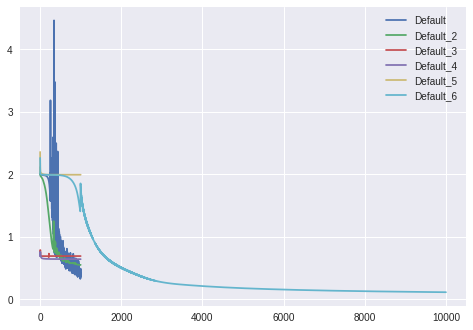

In [129]:
plt.plot(loss1.numpy(), label="Default");
plt.plot(loss2.numpy(), label="Default_2");
plt.plot(loss3.numpy(), label="Default_3");
plt.plot(loss4.numpy(), label="Default_4");
plt.plot(loss5.numpy(), label="Default_5");
plt.plot(loss6.numpy(), label="Default_6");
plt.legend(["Default", "Default_2", "Default_3", "Default_4", "Default_5", "Default_6"]);

In [0]:
p = generate_grid_data(minn=0, maxx=1, num_of_points_per_dim=51, is_torch=True)

In [0]:
out1 = seq1.predict(p)
out2 = seq2.predict(p)
out3 = seq3.predict(p)
out4 = seq4.predict(p)
out5 = seq5.predict(p)
out6 = seq6.predict(p)



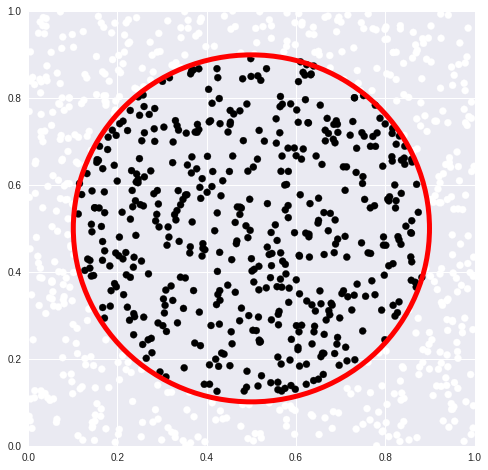

In [131]:
plot_data(points, labels)

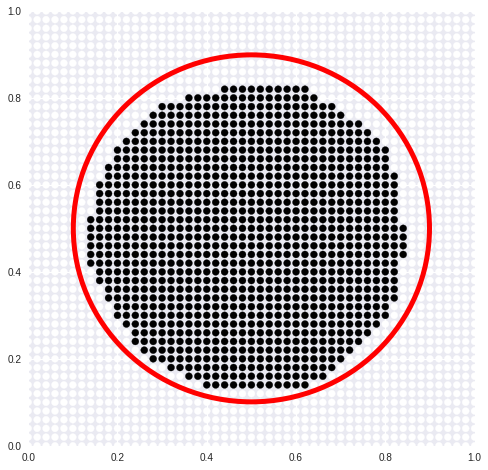

In [132]:
plot_data(p, out1)

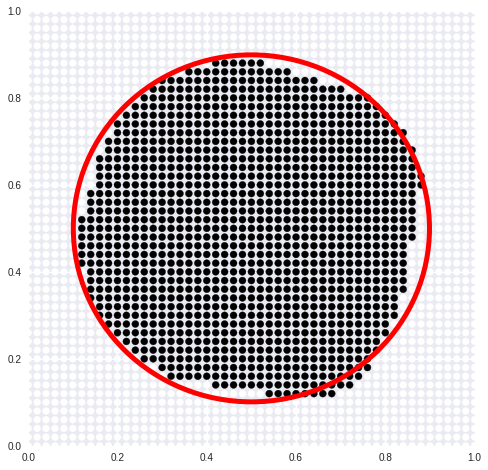

In [133]:
plot_data(p, out2)

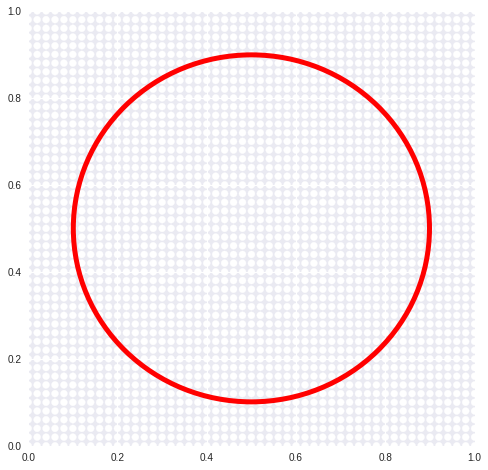

In [134]:
plot_data(p, out3)

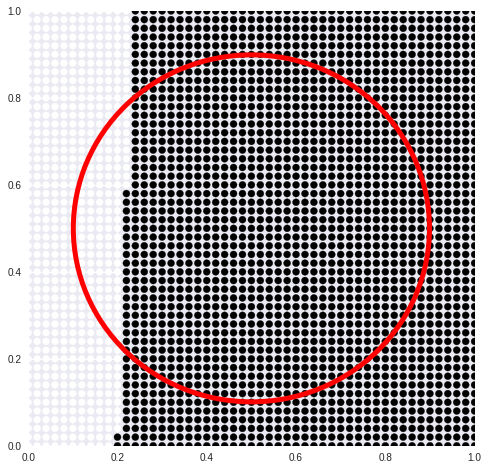

In [135]:
plot_data(p, out4)

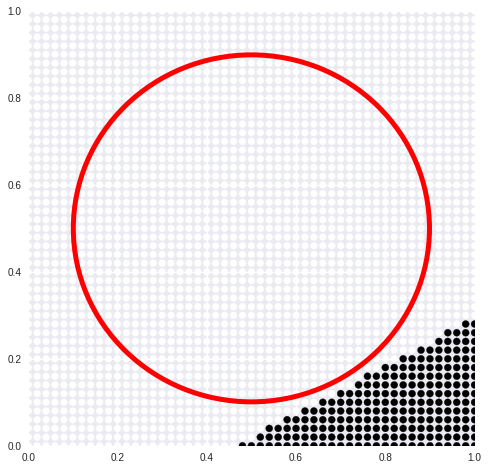

In [136]:
plot_data(p, out5)

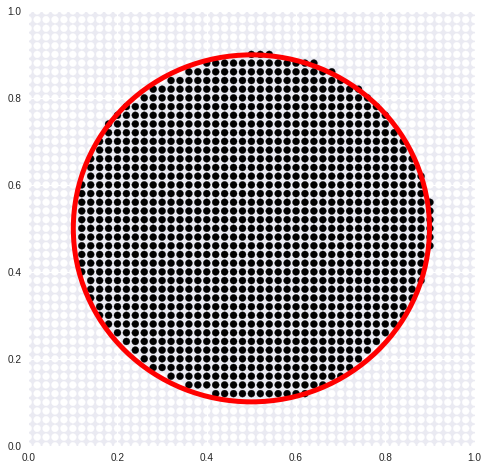

In [137]:
plot_data(p, out6)